# Anomaly Detection of Cyber Intrusion

## Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
from pandas.plotting import radviz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.pickle import to_pickle
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours,InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalanceCascade, EasyEnsemble, BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import time
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.max_rows = 5000

In [2]:
df = pd.read_pickle('datasets/cleaned.pkl')

In [3]:
labels = pd.read_pickle('datasets/labels.pkl')

In [5]:
numcol = list(df.select_dtypes(exclude=['category']).columns)
numcol

['Source_Port',
 'Destination_Port',
 'Flow_Duration',
 'Total_Fwd_Packets',
 'Total_Backward_Packets',
 'Total_Length_of_Fwd_Packets',
 'Total_Length_of_Bwd_Packets',
 'Fwd_Packet_Length_Max',
 'Fwd_Packet_Length_Min',
 'Fwd_Packet_Length_Mean',
 'Fwd_Packet_Length_Std',
 'Bwd_Packet_Length_Max',
 'Bwd_Packet_Length_Min',
 'Bwd_Packet_Length_Mean',
 'Bwd_Packet_Length_Std',
 'Flow_Bytes_persec',
 'Flow_Packets_persec',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Total',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Total',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Fwd_Header_Length',
 'Bwd_Header_Length',
 'Fwd_Packets_persec',
 'Bwd_Packets_persec',
 'Min_Packet_Length',
 'Max_Packet_Length',
 'Packet_Length_Mean',
 'Packet_Length_Std',
 'Packet_Length_Variance',
 'FIN_Flag_Count',
 'SYN_Flag_Count',
 'RST_Flag_Count',
 'PSH_Flag_Count',
 'ACK_Flag_Count',
 'UR

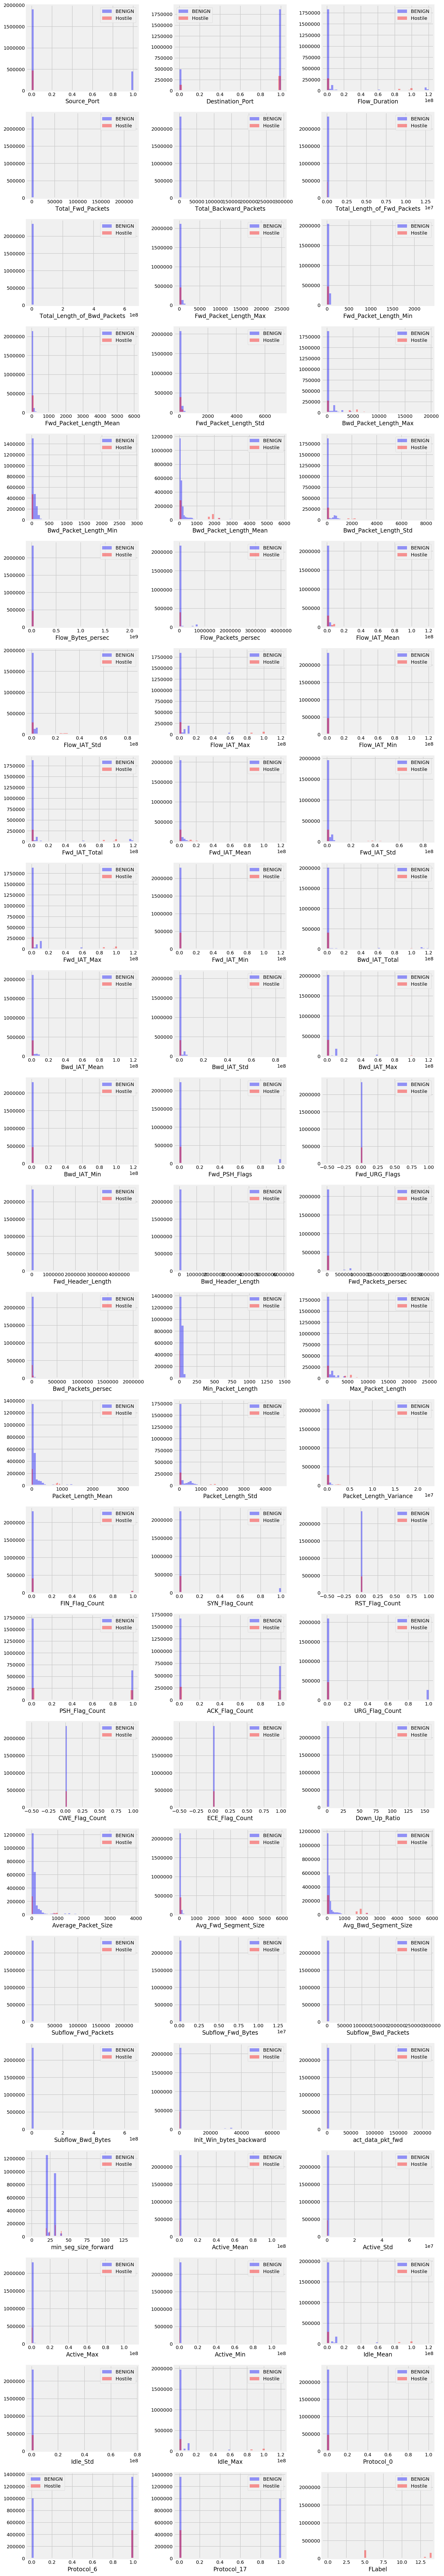

In [8]:
# Plot distribution plot of all features
fig, ax = plt.subplots(24, 3, figsize=(13,75))

for idx, colname in enumerate(numcol):
    plt.subplot(24, 3, idx+1)
    _ = sns.distplot(df[df['Label'] == 'BENIGN'][colname], kde=False, color='blue', label='BENIGN')
    _ = sns.distplot(df[df['Label'] != 'BENIGN'][colname], kde=False, color='red', label='Hostile')
    plt.legend(loc='best', shadow=False)

plt.margins(0.02)
plt.tight_layout()
plt.show()

In [9]:
benign = df[df['Label'] == 'BENIGN']
hostile = df[df['Label'] != 'BENIGN']

In [10]:
hostile.shape

(471454, 77)

In [11]:
# Down sample the benign class
bsbenign = benign.iloc[list(np.random.choice(range(benign.shape[0]), hostile.shape[0]))]
bsbenign.shape

(471454, 77)

In [13]:
toy = pd.concat([bsbenign, hostile], ignore_index=True)
toy.shape

(942908, 77)

In [14]:
toy.Label.value_counts()

BENIGN                        471454
DoS Hulk                      231073
PortScan                      158930
DDoS                           41835
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Infiltration                      36
Web Attack – Sql Injection        21
Heartbleed                        11
Name: Label, dtype: int64

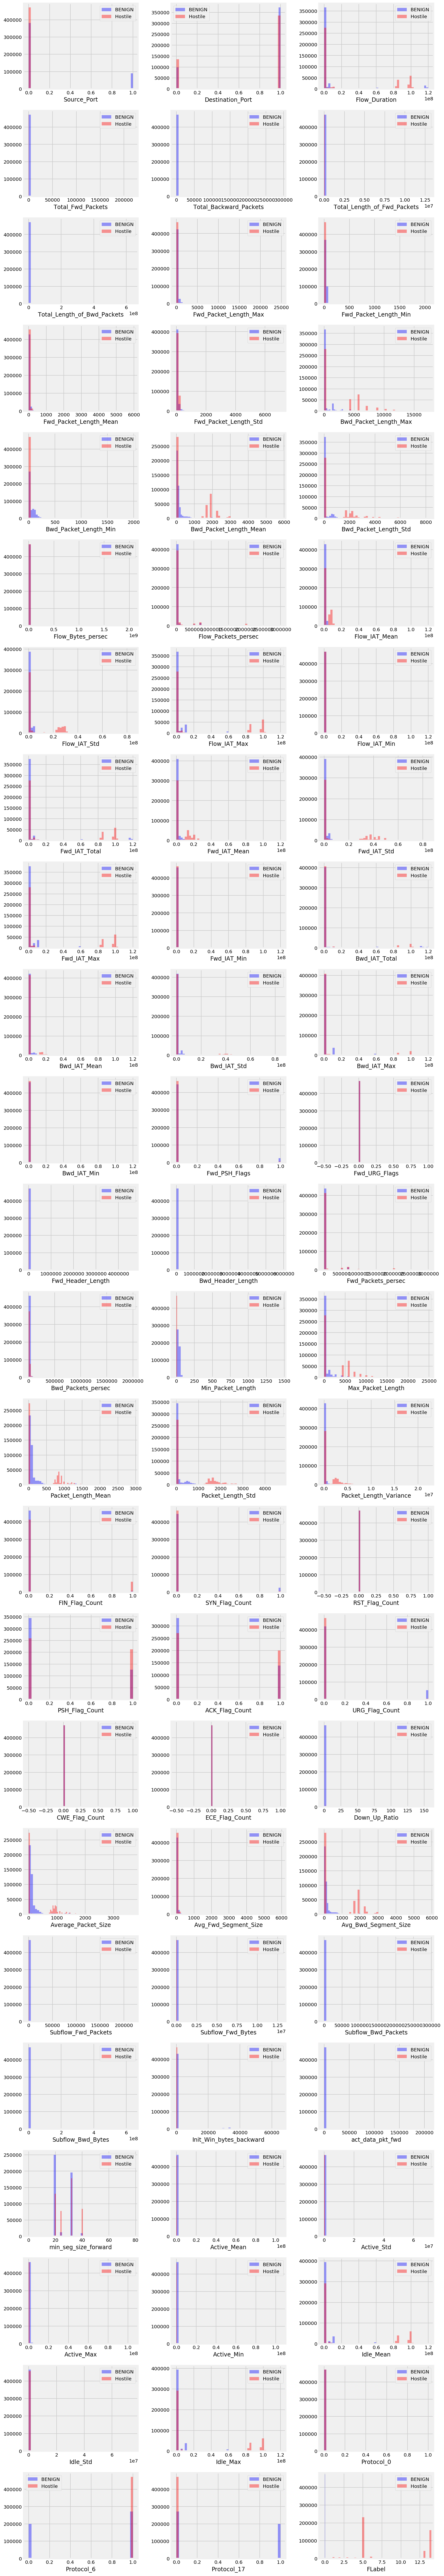

In [15]:
# Replot distribution plot of all features
fig, ax = plt.subplots(24, 3, figsize=(13,75))

for idx, colname in enumerate(numcol):
    plt.subplot(24, 3, idx+1)
    _ = sns.distplot(toy[toy['Label'] == 'BENIGN'][colname], kde=False, color='blue', label='BENIGN')
    _ = sns.distplot(toy[toy['Label'] != 'BENIGN'][colname], kde=False, color='red', label='Hostile')
    plt.legend(loc='best', shadow=False)

plt.margins(0.02)
plt.tight_layout()
plt.show()

The distribution plots of all 72 of the numerical
features, each feature comparing the distribution between the benign
class and hostile classes. Because of the large amount of benign class,
the hostile classes' distribution were not very visible in the each feature's
plot.

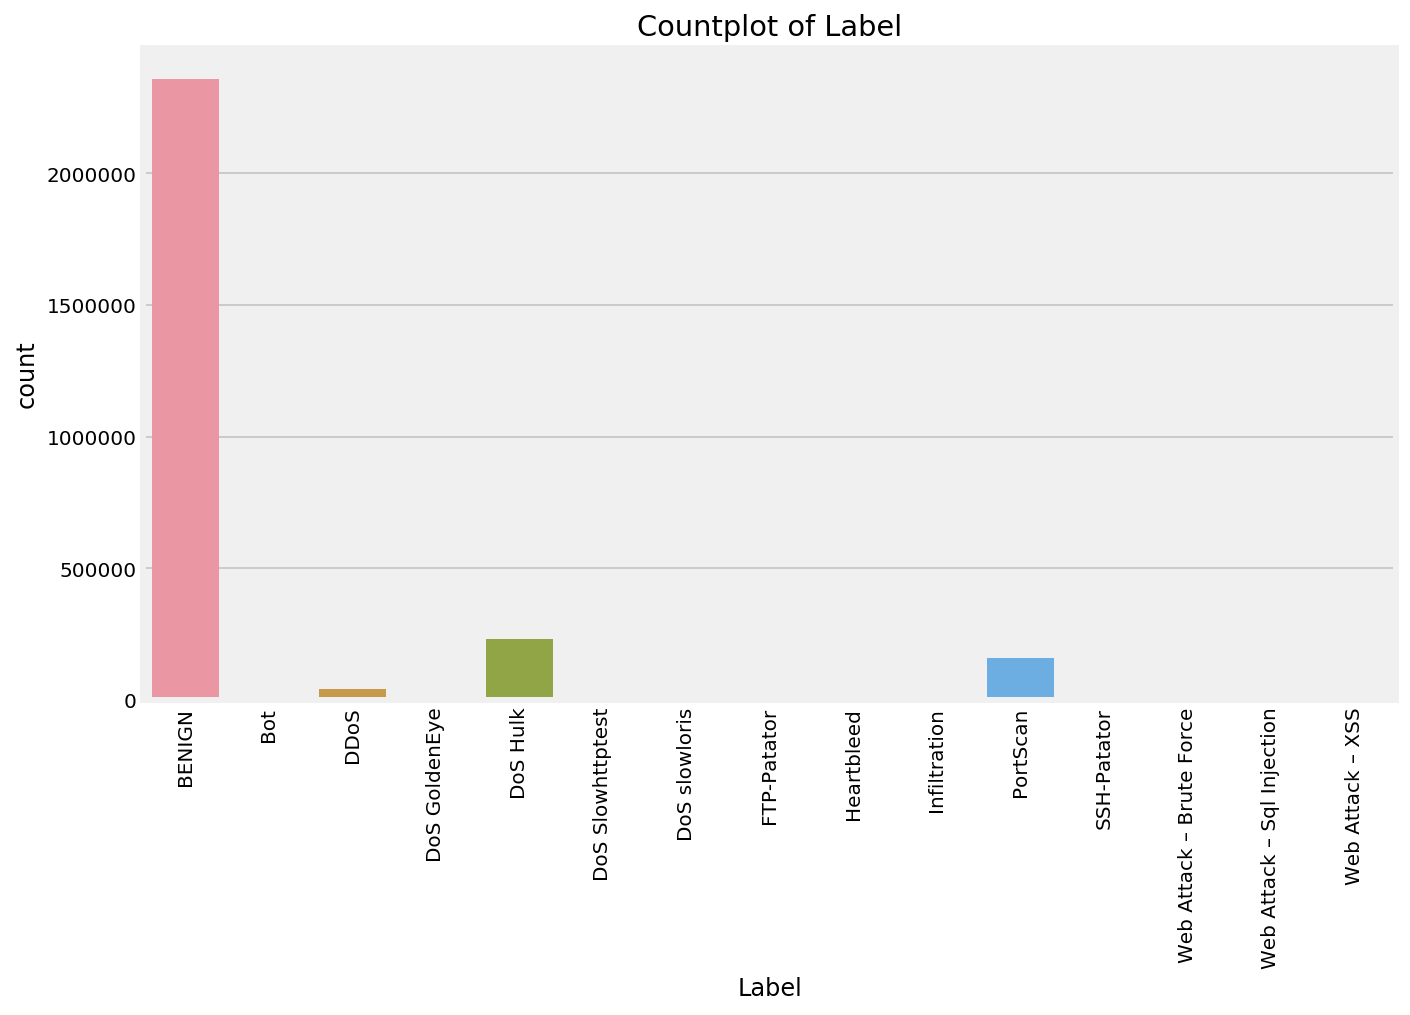

In [28]:
plt.figure(figsize=(10,6))
_ = sns.countplot(df.Label)
plt.xticks(rotation=90)
plt.title('Countplot of Label')
plt.show()

You can see that the imbalances between the classes are huge, some of
the hostile classes are so scarce that they cannot be seen when plotted
together with the 'BENIGN' class.

The following is the proportion of the classes in numerical
representation:

  **Label**                    | **Count**|  **Proportion**
  -----------------------------| ---------|----------------
  BENIGN                       | 2359289  |   0.8334521
  Bot                          | 1966     |   0.00069513
  DDoS                         | 41835    |   0.01477914
  DoS GoldenEye                | 10293    |   0.0036367
  DoS Hulk                     | 231073   |   0.0816306
  DoS Slowhttptest             | 5499     |   0.0019435
  DoS slowloris                | 5796     |   0.0020484
  FTP-Patator                  | 7938     |   0.0028042
  Heartbleed                   | 11       |   0.0000048
  Infiltration                 | 36       |   0.00001312
  PortScan                     | 158930   |   0.056144
  SSH-Patator                  | 5897     |   0.0020833
  Web Attack -- Brute Force    | 1507     |   0.0005329
  Web Attack -- Sql Injection  | 21       |   0.00000711
  Web Attack -- XSS            | 652      |   0.0002301

Hostile classes such as *'Heartbleed', 'Infiltration', 'Web Attack --
Sql Injection', 'Bot', 'Web Attack -- Brute Force'* and *'Web Attack --
XSS'* are indeed very scarce (not even 0.01% of whole dataset!), it will
likely be very difficult to class these accurately but let's see what I
can do.

## Features Selection

There are various methods available to select features.

I first attempted to eliminate features by applying LASSO penalty with a
cross validated logistic regression on the dataset. By doing that the
LASSO penalty will shrink coefficients of weaker features to zero.
However, it seems like due to the size of the data, the code did not
manage to complete even after a day (24hrs).

To move on due to the limited time frame I have, I tried Recursive
feature elimination (RFE) next. RFE repeatedly constructs a model (in my
case logistic regression), sets aside either the best or worst
performing feature in predicting the target variable and then repeating
the process with the rest of the features. Features are then ranked
according to when they were eliminated. Similarly, this method was too
time consuming for the dataset.

Finally, I opted to select the features with highest pearson correlation
with the target variable. 

In [7]:
corr = df.corr()
corr['FLabel'].sort_values(ascending=False)

FLabel                         1.000000
Protocol_6                     0.287476
PSH_Flag_Count                 0.285337
Bwd_Packet_Length_Std          0.202821
Fwd_IAT_Std                    0.197974
Bwd_Packet_Length_Max          0.188493
Idle_Max                       0.182229
min_seg_size_forward           0.178138
Idle_Mean                      0.177665
Avg_Bwd_Segment_Size           0.177442
Bwd_Packet_Length_Mean         0.177442
Fwd_IAT_Max                    0.177272
Flow_IAT_Max                   0.176214
Packet_Length_Variance         0.174567
Packet_Length_Std              0.168487
Max_Packet_Length              0.166476
Flow_IAT_Std                   0.146406
Packet_Length_Mean             0.122360
Average_Packet_Size            0.118522
Bwd_Packets_persec             0.106139
FIN_Flag_Count                 0.077451
Fwd_IAT_Total                  0.072478
Idle_Std                       0.072415
Flow_Duration                  0.070407
Flow_IAT_Mean                  0.064519


In [8]:
fivepct = corr[abs(corr['FLabel']) > 0.05]['FLabel'].sort_values(ascending=False)
fivepct

FLabel                     1.000000
Protocol_6                 0.287476
PSH_Flag_Count             0.285337
Bwd_Packet_Length_Std      0.202821
Fwd_IAT_Std                0.197974
Bwd_Packet_Length_Max      0.188493
Idle_Max                   0.182229
min_seg_size_forward       0.178138
Idle_Mean                  0.177665
Avg_Bwd_Segment_Size       0.177442
Bwd_Packet_Length_Mean     0.177442
Fwd_IAT_Max                0.177272
Flow_IAT_Max               0.176214
Packet_Length_Variance     0.174567
Packet_Length_Std          0.168487
Max_Packet_Length          0.166476
Flow_IAT_Std               0.146406
Packet_Length_Mean         0.122360
Average_Packet_Size        0.118522
Bwd_Packets_persec         0.106139
FIN_Flag_Count             0.077451
Fwd_IAT_Total              0.072478
Idle_Std                   0.072415
Flow_Duration              0.070407
Flow_IAT_Mean              0.064519
Bwd_IAT_Std                0.052382
Fwd_IAT_Mean               0.051715
Fwd_Packet_Length_Std     -0

The highest correlation were 0.287476 and
-0.287116. I decided to filter out features with less than 0.05
correlation and with the remaining features, I plotted a heatmap:

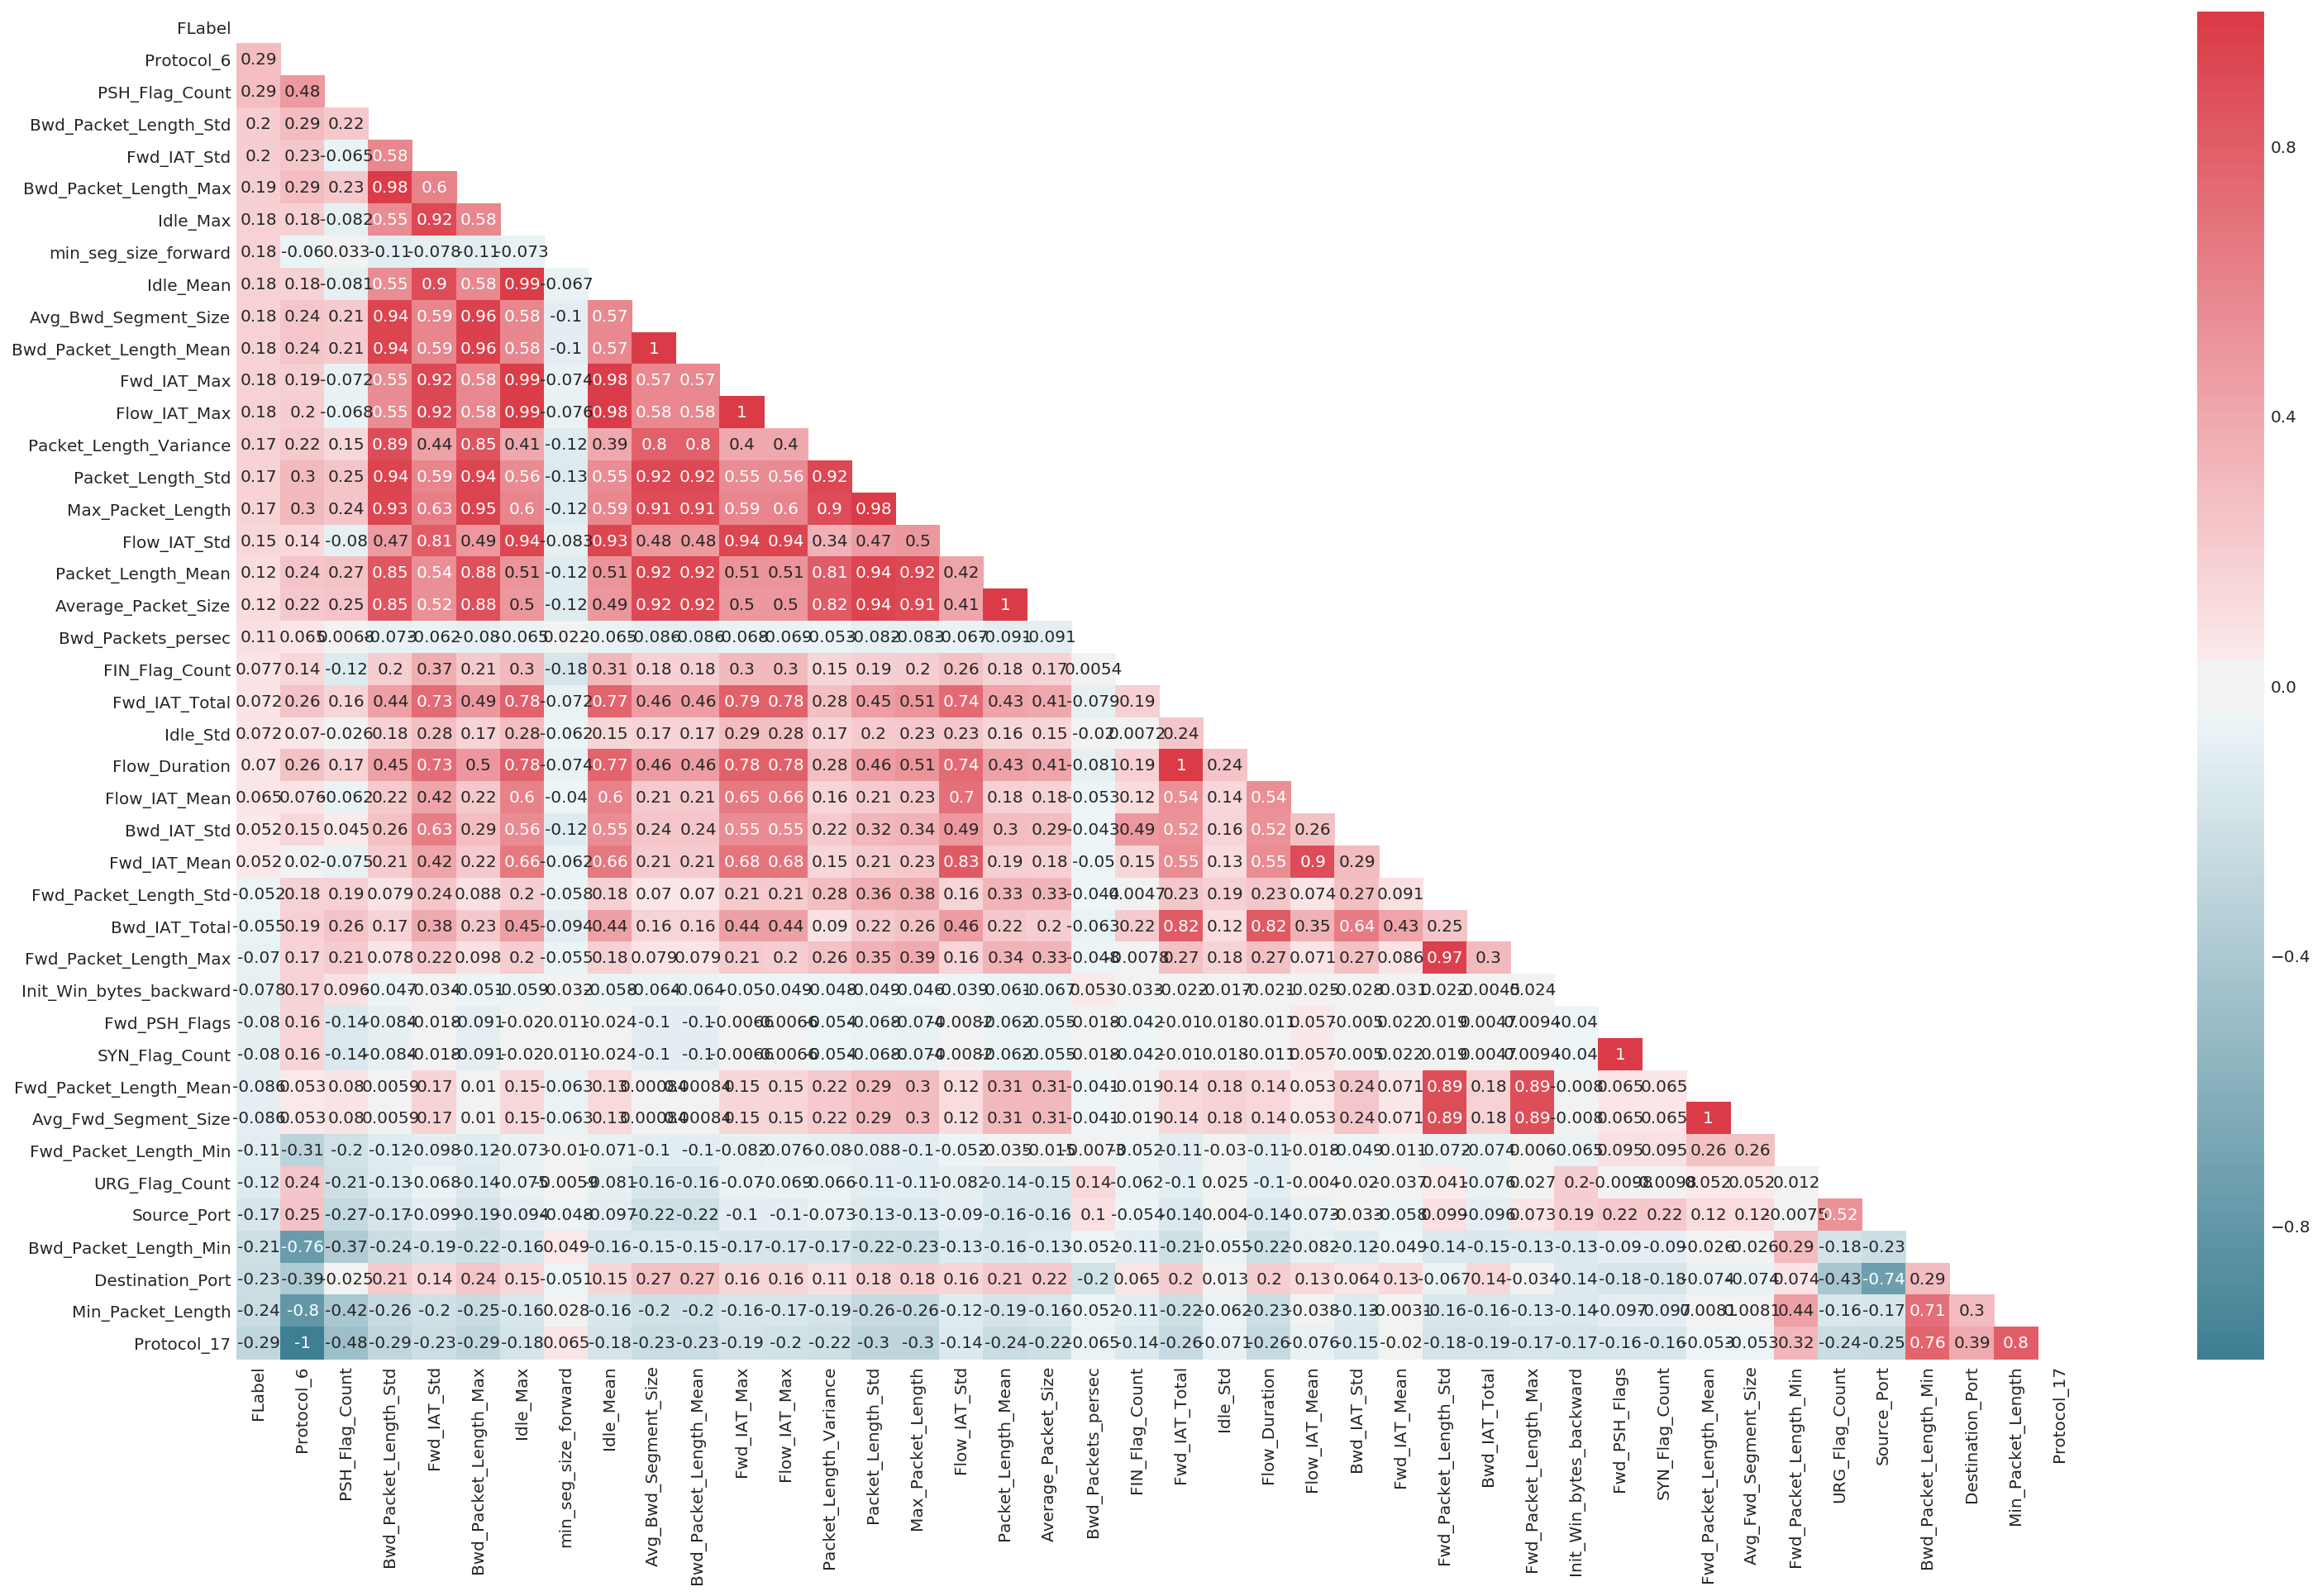

In [9]:
fivepctcorr = df[fivepct.index].corr()
ax = plt.figure(figsize=(25,15))
ax = plt.gca()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(fivepctcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(fivepctcorr, annot=True, mask=mask, ax=ax, cmap=cmap)
plt.show()

With the heatmap, I was able to remove the independent features which
have high correlation with other independent features, in order to
prevent multicollinearity.

Multicollinearity increases the variance of the coefficient estimates
and make the estimates very sensitive to minor changes in the model.
This will result in the coefficient estimates being unstable and
difficult to interpret.

After eliminating the highly correlated features, the following 17
features were chosen

In [10]:
features = ['Protocol_6','PSH_Flag_Count','Bwd_Packet_Length_Std','Fwd_IAT_Std','min_seg_size_forward','Bwd_Packets_persec',
            'FIN_Flag_Count','Idle_Std','Flow_IAT_Mean','Bwd_IAT_Std','Bwd_IAT_Total','Init_Win_bytes_backward',
            'SYN_Flag_Count','Avg_Fwd_Segment_Size','Fwd_Packet_Length_Min','URG_Flag_Count','Destination_Port']

In [11]:
y = df.loc[:, 'Label']
X = df.loc[:, features]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=101, stratify=y)

In [17]:
y_test.value_counts()

BENIGN                        589784
DoS Hulk                       57768
PortScan                       39733
DDoS                           10459
DoS GoldenEye                   2573
FTP-Patator                     1985
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1375
Bot                              491
Web Attack – Brute Force         377
Web Attack – XSS                 163
Infiltration                       9
Web Attack – Sql Injection         5
Heartbleed                         3
Name: Label, dtype: int64

In [18]:
labellist = []
for label in labels.Label.values:
    for l in label:
        labellist.append(l)

labellist.sort()
labellist

['BENIGN',
 'Bot',
 'DDoS',
 'DoS GoldenEye',
 'DoS Hulk',
 'DoS Slowhttptest',
 'DoS slowloris',
 'FTP-Patator',
 'Heartbleed',
 'Infiltration',
 'PortScan',
 'SSH-Patator',
 'Web Attack – Brute Force',
 'Web Attack – Sql Injection',
 'Web Attack – XSS']

In [19]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

**RadViz Plot**

RadViz is a multivariate data visualization algorithm that 
plots each axis uniformly around the circumference of a circle 
then plots points on the interior of the circle such that the 
point normalizes its values on the axes from the center to 
each arc

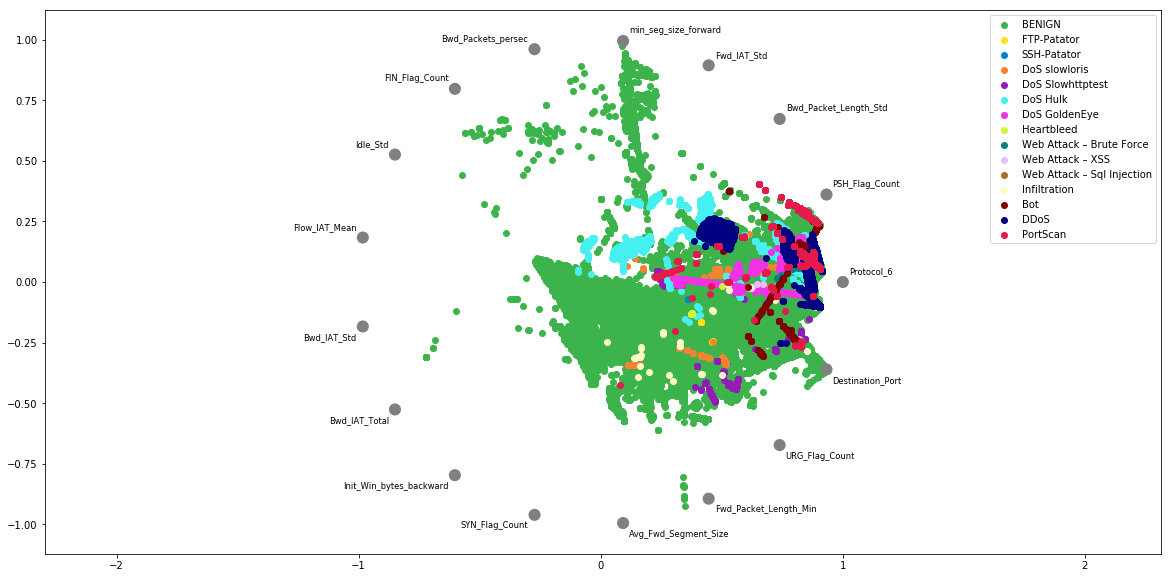

In [31]:
colors=['#3cb44b','#ffe119','#0082c8','#f58231','#911eb4','#46f0f0','#f032e6','#d2f53c',
        '#008080','#e6beff','#aa6e28','#fffac8','#800000','#000080','#e6194b']

plt.figure(figsize=(20,10))
radviz(df[features + ['Label']], 'Label', color=colors)
plt.show()

In the Radviz implementation, N-dimensions are laid out as points equally spaced around the perimeter of a circle. One end of N springs are attached to these N perimeter points. The other ends of the springs are attached to a data point. The spring constant K equals the value of the particular dimension of the fixed point. For each data point the position is placed where the sum of the spring forces equals 0. That data point values are usually normalized to have values between 0 and 1.

- points where all dimensional values have approximately the same value will lie close to the center.
- If dimensional points lie opposite each other on the circle and have similar values than points will lie near the center.
- If 1 or 2 dimensional values are greater, points will lie closer to those dimensional points.
- Where a point will lie depends on the layout of the particular dimensions around the circle.
- This is a non-linear projection from N-dimensions down to 2 dimensions
- Certain symmetries of the data will be preserved.
- The layout of the data can be intuitively understood.